<pre>
Name: Ritika Sarkar
Reg. No.: 19BAI1031
</pre>

## Convolutional Neural Network (CNN)

Dataset - [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)

In [2]:
# modules imported
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from skimage import io
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import pydicom as pyd
import cv2
import tqdm

In [3]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
#from gradcam import VizGradCAM
from keras import backend as K

In [4]:
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [5]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
df['path'] = '../input/histopathologic-cancer-detection/train/'+df['id']+'.tif'

In [7]:
df.iloc[0][2]

'../input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif'

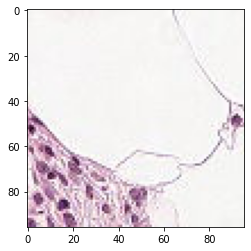

In [8]:
image = plt.imread(df.iloc[0][2])
plt.imshow(image)

In [9]:
df.shape[0]

220025

In [10]:
df

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../input/histopathologic-cancer-detection/trai...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../input/histopathologic-cancer-detection/trai...
2,755db6279dae599ebb4d39a9123cce439965282d,0,../input/histopathologic-cancer-detection/trai...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../input/histopathologic-cancer-detection/trai...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../input/histopathologic-cancer-detection/trai...
...,...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,../input/histopathologic-cancer-detection/trai...
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,../input/histopathologic-cancer-detection/trai...
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,../input/histopathologic-cancer-detection/trai...
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0,../input/histopathologic-cancer-detection/trai...


#### Split to test set 

In [11]:
df['id'] = df['id']+'.tif'

In [12]:
df.head()

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0,../input/histopathologic-cancer-detection/trai...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1,../input/histopathologic-cancer-detection/trai...
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0,../input/histopathologic-cancer-detection/trai...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0,../input/histopathologic-cancer-detection/trai...
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0,../input/histopathologic-cancer-detection/trai...


In [13]:
np.random.seed(100)
val_array = np.random.choice(os.listdir('../input/histopathologic-cancer-detection/train/'), 10000) 

In [14]:
val_df = df[df.id.isin(val_array)].reset_index()

In [15]:
val_df.drop('index', axis =1, inplace=True)

In [16]:
val_df.tail()

,id,label,path
9764,3619fef8051e9cea8908ab7d7bfaeb51566312fb.tif,0,../input/histopathologic-cancer-detection/trai...
9765,241b1941a327b70a7ff80295c8e089c1c7353aa3.tif,0,../input/histopathologic-cancer-detection/trai...
9766,645adcab3f170b2199a5bcc358b4233687d24a15.tif,0,../input/histopathologic-cancer-detection/trai...
9767,ebdcf501c59924cb41ffe36ea6474f6f441ed811.tif,0,../input/histopathologic-cancer-detection/trai...
9768,449275b9ab37371753fe63bba30870504c56560b.tif,1,../input/histopathologic-cancer-detection/trai...


In [17]:
val_df.label.value_counts()

0    5823
1    3946
Name: label, dtype: int64

In [18]:
val_df = pd.concat([val_df[val_df.label==0].sample(n=3000),val_df[val_df.label==1].sample(n=3000)]) 

In [19]:
val_df['label'].value_counts()

0    3000
1    3000
Name: label, dtype: int64

In [20]:
val_df.reset_index(drop = True, inplace = True)

In [21]:
val_df.tail()

,id,label,path
5995,4c4e78903c7f55e34646355ef2be903cd9bb3f8e.tif,1,../input/histopathologic-cancer-detection/trai...
5996,03acb9c7823095495b1266ad8f15f06828878798.tif,1,../input/histopathologic-cancer-detection/trai...
5997,17abe23b17c587afaf1653b90b02cc9aaf7312e1.tif,1,../input/histopathologic-cancer-detection/trai...
5998,1d0b10552558bf7a98b34f3d96e1646aa237f7cf.tif,1,../input/histopathologic-cancer-detection/trai...
5999,c9c0e152ec1adeea182b7dd99eeb9ce1ddcdc91c.tif,1,../input/histopathologic-cancer-detection/trai...


##### Remove the common instances from training set

In [22]:
common = df['id'].isin(val_df['id'])
df.drop(df[common].index, inplace = True)

In [23]:
df.reset_index(drop = True, inplace = True)

In [24]:
df.tail()

,id,label,path
214020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0,../input/histopathologic-cancer-detection/trai...
214021,d4b854fe38b07fe2831ad73892b3cec877689576.tif,1,../input/histopathologic-cancer-detection/trai...
214022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0,../input/histopathologic-cancer-detection/trai...
214023,f129691c13433f66e1e0671ff1fe80944816f5a2.tif,0,../input/histopathologic-cancer-detection/trai...
214024,a81f84895ddcd522302ddf34be02eb1b3e5af1cb.tif,1,../input/histopathologic-cancer-detection/trai...


##### Addressing class imbalance in training set

In [25]:
# equalizing the contribution of both classes
dfnew = pd.concat([df[df.label==0].sample(n=10000),df[df.label==1].sample(n=10000)]) # 10000 samples and reducing the effect of class imbalance by taking equal

In [26]:
dfnew['label'].value_counts()

0    10000
1    10000
Name: label, dtype: int64

In [27]:
dfnew.reset_index(drop = True, inplace = True)

In [28]:
dfnew.tail()

,id,label,path
19995,8fcd3b2686e112dc4765b9361db224f3e6fed7db.tif,1,../input/histopathologic-cancer-detection/trai...
19996,f5c79dd3e983af3aba0c55bf0ec29d67e8227ffa.tif,1,../input/histopathologic-cancer-detection/trai...
19997,41fd030db35051c611a1fd6b7eb081fc49ad613f.tif,1,../input/histopathologic-cancer-detection/trai...
19998,17c74ea2a924828144b20b2926dcee300c1944f2.tif,1,../input/histopathologic-cancer-detection/trai...
19999,1a06c8ddef988407b75a5872e583708e2ba55f3b.tif,1,../input/histopathologic-cancer-detection/trai...


In [46]:
BATCH_SIZE = 8 # 32 is too much, gives warning message due to excess memory usage (increasing batch size may give better accuracy)
#https://stackoverflow.com/questions/50304156/tensorflow-allocation-memory-allocation-of-38535168-exceeds-10-of-system-memor

def create_datagen():
    return ImageDataGenerator()

def create_train_gen(datagen):
    return datagen.flow_from_dataframe(
        dfnew, 
        directory = '../input/histopathologic-cancer-detection/train/',
        
        x_col = 'id', 
        y_col = 'label',
        class_mode = 'raw',
        target_size = (150, 150),
        batch_size = BATCH_SIZE,
#         subset = 'training'
       
    )
def create_test_gen(datagen): 
    return datagen.flow_from_dataframe(
        val_df, 
        directory='../input/histopathologic-cancer-detection/train/',
        
        x_col='id', 
        y_col = 'label',
        class_mode = 'raw',
        target_size = (150, 150),
        batch_size = BATCH_SIZE,
        shuffle = False,

    )


# Using image data generator to generate batches of images of '.tif' format
data_generator = create_datagen()
train_gen = create_train_gen(data_generator)
test_gen = create_test_gen(data_generator)

Found 20000 validated image filenames.
Found 6000 validated image filenames.


In [47]:
num_train = train_gen.samples # number of training data
num_test = test_gen.samples

In [48]:
# simple CNN model 
model = tf.keras.Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape = (150,150,3)))
model.add(tf.keras.layers.AveragePooling2D())
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) # binary classes

# Compile the model
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = optimizers.Adam(learning_rate = 0.001))

In [49]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
average_pooling2d_1 (Average (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                5607456   
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 5,608,385
Trainable params: 5,608,385
Non-trainable params: 0
____________________________________________

In [50]:
# training 
EPOCHS = 15
history = model.fit(
    train_gen,
    steps_per_epoch = num_train//16,
    epochs = EPOCHS
)

Epoch 1/15
1250/1250 [==============================] - 17s 13ms/step - loss: 150.9792 - accuracy: 0.5657
Epoch 2/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.7312 - accuracy: 0.6452
Epoch 3/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5610 - accuracy: 0.7099
Epoch 4/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5035 - accuracy: 0.7435
Epoch 5/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4708 - accuracy: 0.7598
Epoch 6/15
1250/1250 [==============================] - 17s 13ms/step - loss: 0.4698 - accuracy: 0.7678
Epoch 7/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4951 - accuracy: 0.7541
Epoch 8/15
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5422 - accuracy: 0.7315
Epoch 9/15
1250/1250 [==============================] - 16s 13ms/step - loss: 0.5307 - accuracy: 0.7319
Epoch 10/15
1250/1250 [==============================] - 17s 1

Text(0, 0.5, 'Accuracy')

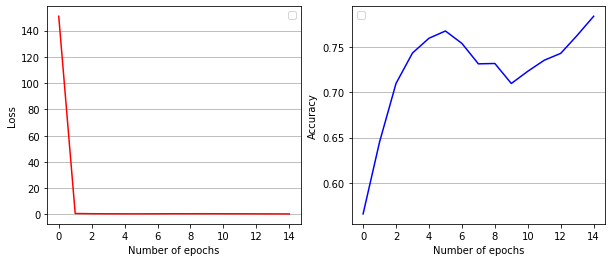

In [51]:
# plotting training loss and accuracy
plt.figure(figsize=(10,4))

ax = plt.subplot(121)
ax.plot(history.history['loss'], 'r')
plt.legend()
plt.grid(axis='y')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

ax2 = plt.subplot(122)
ax2.plot(history.history['accuracy'], 'b')
plt.grid(axis='y')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

In [52]:
# predict on test set
predicted_vals = model.predict(test_gen)

In [54]:
y_true = test_gen.labels
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [55]:
# setting values above 0.5 to 1 else 0
y_preds = []
for i in range(len(predicted_vals)):
    y_preds.append(0)
    for value in predicted_vals[i]: 
        if value > 0.5: 
            y_preds[i] = 1
            break
            
len(y_preds)

6000

In [56]:
from sklearn.metrics import confusion_matrix
print('2*2 Confusion Matrix')
print(confusion_matrix(y_true, y_preds))

2*2 Confusion Matrix
[[1368 1632]
 [1058 1942]]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.56      0.46      0.50      3000
           1       0.54      0.65      0.59      3000

    accuracy                           0.55      6000
   macro avg       0.55      0.55      0.55      6000
weighted avg       0.55      0.55      0.55      6000



In [58]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
score = roc_auc_score(y_true, y_preds)
roc_auc_score(y_true, y_preds)

0.5516666666666666

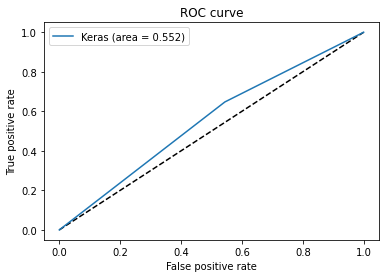

In [59]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_preds)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Observation
1. The training accuracy increases barring one dip for a few epochs and attains 78.41% accuracy after training for 15 epochs.
2. The CNN model is a Sequential model with one Conv2D layer with 32 filters, an AveragePooling2D layer and then Flatten. A Dense layer with 32 neurons and Dropout of 30% is introduced to avoid overfitting. Finally a Dense output layer with sigmoid activation function is chosen for binary classification of tumour cells from the '.tif' slide images.
3. However the prediction accuracy is poor and can be because of newer examples in the test set which the classifier hasn't seen yet. Hence the training examples need to be increased for this domain for the classification accuracy to increase.
4. It is observed that the recall is higher for class 1, while lower for class 0, which means misclassifications for class 0 were higher. The system can be considered for deploying since the identification of the class 1 is more necessary and false negatives can be dealt with.